In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Idea
Create the diagonal of the fock matrix via nn, then use gwh to create rest of the fock matrix

# Data 

In [2]:
data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"
subfolder = "EmbeddedBlocks/"

#data_path = "../../../cc2ai/ethen/"
#postfix = "_ethen_6-31g**"
#dim = 48
#N_ELECTRONS = 16
#basis = "6-31g**"

#data_path = "../thesis/dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(S))
#ind = len(S)


molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test, p_test = S.reshape(-1, dim, dim), P.reshape(-1, dim, dim)

In [4]:
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

f_test = fock_from_density_batch(p_test)

In [5]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

# Calculate classical Guesses 

In [6]:
from pyscf.scf import hf

In [7]:
p_gwh = [
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]

# GWH Scheme

TODO: decide on the best k!

In [8]:
from SCFInitialGuess.utilities.dataset import density_from_fock

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)


In [9]:
from SCFInitialGuess.construction.fock import gwh_scheme

def gwh_scheme_wrapper(M, k=1.75):
    F = []
    for m, s in zip(M, s_test):
        F.append(gwh_scheme(np.diag(m), s, k))
        
    return np.array(F)

In [10]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    density_from_fock_batch(gwh_scheme_wrapper(h_test)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-02 11:33:07: Iteration calculation: 0
[ ] 2019-01-02 11:33:10: Iteration calculation: 1
[ ] 2019-01-02 11:33:12: Iteration calculation: 2
[ ] 2019-01-02 11:33:14: Iteration calculation: 3
[ ] 2019-01-02 11:33:17: Iteration calculation: 4
[ ] 2019-01-02 11:33:19: Iteration calculation: 5
[ ] 2019-01-02 11:33:21: Iteration calculation: 6
[ ] 2019-01-02 11:33:23: Iteration calculation: 7
[ ] 2019-01-02 11:33:24: Iteration calculation: 8
[ ] 2019-01-02 11:33:25: Iteration calculation: 9
[ ] 2019-01-02 11:33:27: Iteration calculation: 10
[ ] 2019-01-02 11:33:29: Iteration calculation: 11
[ ] 2019-01-02 11:33:30: Iteration calculation: 12
[ ] 2019-01-02 11:33:31: Iteration calculation: 13
[ ] 2019-01-02 11:33:33: Iteration calculation: 14
[ ] 2019-01-02 11:33:34: Iteration calculation: 15
[ ] 2019-01-02 11:33:36: Iteration calculation: 16
[ ] 2019-01-02 11:33:36: Iteration calculation: 17
[ ] 2019-01-02 11:33:37: Iteration calculation: 18
[ ] 2019-01-02 11:33:39: Iteration calcul

[ ] 2019-01-02 11:37:12: Iteration calculation: 160
[ ] 2019-01-02 11:37:14: Iteration calculation: 161
[ ] 2019-01-02 11:37:15: Iteration calculation: 162
[ ] 2019-01-02 11:37:16: Iteration calculation: 163
[ ] 2019-01-02 11:37:18: Iteration calculation: 164
[ ] 2019-01-02 11:37:19: Iteration calculation: 165
[ ] 2019-01-02 11:37:21: Iteration calculation: 166
[ ] 2019-01-02 11:37:22: Iteration calculation: 167
[ ] 2019-01-02 11:37:24: Iteration calculation: 168
[ ] 2019-01-02 11:37:25: Iteration calculation: 169
[ ] 2019-01-02 11:37:27: Iteration calculation: 170
[ ] 2019-01-02 11:37:27: Iteration calculation: 171
[ ] 2019-01-02 11:37:29: Iteration calculation: 172
[ ] 2019-01-02 11:37:29: Iteration calculation: 173
[ ] 2019-01-02 11:37:31: Iteration calculation: 174
[ ] 2019-01-02 11:37:32: Iteration calculation: 175
[ ] 2019-01-02 11:37:34: Iteration calculation: 176
[ ] 2019-01-02 11:37:35: Iteration calculation: 177
[ ] 2019-01-02 11:37:37: Iteration calculation: 178
[ ] 2019-01-

# Extended Hückel 

In [11]:
f_nn_gwh = gwh_scheme_wrapper(f_test, k=1.75)

In [12]:
np.mean(np.abs(
    np.array(list(map(np.diag, f_nn_gwh))).flatten() - \
        np.array(list(map(np.diag, f_test))).flatten()
))

3.230771141199422e-16

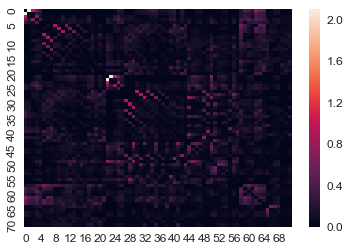

In [13]:
sns.heatmap(np.abs(f_nn_gwh[0] - f_test[0]))

In [14]:
p_nn_gwh = density_from_fock_batch(f_nn_gwh)

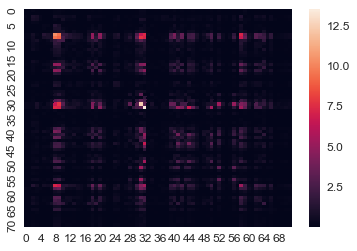

In [15]:
sns.heatmap(np.abs(p_nn_gwh[0] - p_test[0]))

In [16]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    p_nn_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-02 11:39:39: Iteration calculation: 0
[ ] 2019-01-02 11:39:40: Iteration calculation: 1
[ ] 2019-01-02 11:39:41: Iteration calculation: 2
[ ] 2019-01-02 11:39:42: Iteration calculation: 3
[ ] 2019-01-02 11:39:43: Iteration calculation: 4
[ ] 2019-01-02 11:39:45: Iteration calculation: 5
[ ] 2019-01-02 11:39:46: Iteration calculation: 6
[ ] 2019-01-02 11:39:47: Iteration calculation: 7
[ ] 2019-01-02 11:39:47: Iteration calculation: 8
[ ] 2019-01-02 11:39:48: Iteration calculation: 9
[ ] 2019-01-02 11:39:48: Iteration calculation: 10
[ ] 2019-01-02 11:39:50: Iteration calculation: 11
[ ] 2019-01-02 11:39:50: Iteration calculation: 12
[ ] 2019-01-02 11:39:52: Iteration calculation: 13
[ ] 2019-01-02 11:39:53: Iteration calculation: 14
[ ] 2019-01-02 11:39:54: Iteration calculation: 15
[ ] 2019-01-02 11:39:55: Iteration calculation: 16
[ ] 2019-01-02 11:39:55: Iteration calculation: 17
[ ] 2019-01-02 11:39:56: Iteration calculation: 18
[ ] 2019-01-02 11:39:58: Iteration calcul

[ ] 2019-01-02 11:42:51: Iteration calculation: 160
[ ] 2019-01-02 11:42:53: Iteration calculation: 161
[ ] 2019-01-02 11:42:53: Iteration calculation: 162
[ ] 2019-01-02 11:42:55: Iteration calculation: 163
[ ] 2019-01-02 11:42:57: Iteration calculation: 164
[ ] 2019-01-02 11:42:58: Iteration calculation: 165
[ ] 2019-01-02 11:43:00: Iteration calculation: 166
[ ] 2019-01-02 11:43:01: Iteration calculation: 167
[ ] 2019-01-02 11:43:02: Iteration calculation: 168
[ ] 2019-01-02 11:43:04: Iteration calculation: 169
[ ] 2019-01-02 11:43:04: Iteration calculation: 170
[ ] 2019-01-02 11:43:05: Iteration calculation: 171
[ ] 2019-01-02 11:43:06: Iteration calculation: 172
[ ] 2019-01-02 11:43:06: Iteration calculation: 173
[ ] 2019-01-02 11:43:08: Iteration calculation: 174
[ ] 2019-01-02 11:43:08: Iteration calculation: 175
[ ] 2019-01-02 11:43:10: Iteration calculation: 176
[ ] 2019-01-02 11:43:11: Iteration calculation: 177
[ ] 2019-01-02 11:43:12: Iteration calculation: 178
[ ] 2019-01-

In [17]:
85/len(p_test)

0.4228855721393035

### Damping 

In [19]:
from SCFInitialGuess.utilities.analysis import statistics

In [20]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-02 11:50:12: Iteration calculation: 0
[ ] 2019-01-02 11:50:13: Iteration calculation: 1
[ ] 2019-01-02 11:50:14: Iteration calculation: 2
[ ] 2019-01-02 11:50:16: Iteration calculation: 3
[ ] 2019-01-02 11:50:17: Iteration calculation: 4
[ ] 2019-01-02 11:50:18: Iteration calculation: 5
[ ] 2019-01-02 11:50:18: Iteration calculation: 6
[ ] 2019-01-02 11:50:19: Iteration calculation: 7
[ ] 2019-01-02 11:50:19: Iteration calculation: 8
[ ] 2019-01-02 11:50:20: Iteration calculation: 9
[ ] 2019-01-02 11:50:20: Iteration calculation: 10
[ ] 2019-01-02 11:50:22: Iteration calculation: 11
[ ] 2019-01-02 11:50:22: Iteration calculation: 12
[ ] 2019-01-02 11:50:23: Iteration calculation: 13
[ ] 2019-01-02 11:50:24: Iteration calculation: 14
[ ] 2019-01-02 11:50:25: Iteration calculation: 15
[ ] 2019-01-02 11:50:26: Iteration calculation: 16
[ ] 2019-01-02 11:50:27: Iteration calculation: 17
[ ] 2019-01-02 11:50:27: Iteration calculation: 18
[ ] 2019-01-02 11:50:28: Iteration calcul

[ ] 2019-01-02 11:53:20: Iteration calculation: 160
[ ] 2019-01-02 11:53:21: Iteration calculation: 161
[ ] 2019-01-02 11:53:22: Iteration calculation: 162
[ ] 2019-01-02 11:53:23: Iteration calculation: 163
[ ] 2019-01-02 11:53:25: Iteration calculation: 164
[ ] 2019-01-02 11:53:27: Iteration calculation: 165
[ ] 2019-01-02 11:53:28: Iteration calculation: 166
[ ] 2019-01-02 11:53:30: Iteration calculation: 167
[ ] 2019-01-02 11:53:30: Iteration calculation: 168
[ ] 2019-01-02 11:53:32: Iteration calculation: 169
[ ] 2019-01-02 11:53:33: Iteration calculation: 170
[ ] 2019-01-02 11:53:34: Iteration calculation: 171
[ ] 2019-01-02 11:53:34: Iteration calculation: 172
[ ] 2019-01-02 11:53:36: Iteration calculation: 173
[ ] 2019-01-02 11:53:37: Iteration calculation: 174
[ ] 2019-01-02 11:53:38: Iteration calculation: 175
[ ] 2019-01-02 11:53:39: Iteration calculation: 176
[ ] 2019-01-02 11:53:41: Iteration calculation: 177
[ ] 2019-01-02 11:53:42: Iteration calculation: 178
[ ] 2019-01-

### DIIS 

In [21]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-02 11:54:03: Iteration calculation: 0
[ ] 2019-01-02 11:54:03: Iteration calculation: 1
[ ] 2019-01-02 11:54:04: Iteration calculation: 2
[ ] 2019-01-02 11:54:04: Iteration calculation: 3
[ ] 2019-01-02 11:54:05: Iteration calculation: 4
[ ] 2019-01-02 11:54:05: Iteration calculation: 5
[ ] 2019-01-02 11:54:05: Iteration calculation: 6
[ ] 2019-01-02 11:54:06: Iteration calculation: 7
[ ] 2019-01-02 11:54:06: Iteration calculation: 8
[ ] 2019-01-02 11:54:07: Iteration calculation: 9
[ ] 2019-01-02 11:54:07: Iteration calculation: 10
[ ] 2019-01-02 11:54:08: Iteration calculation: 11
[ ] 2019-01-02 11:54:08: Iteration calculation: 12
[ ] 2019-01-02 11:54:08: Iteration calculation: 13
[ ] 2019-01-02 11:54:09: Iteration calculation: 14
[ ] 2019-01-02 11:54:09: Iteration calculation: 15
[ ] 2019-01-02 11:54:10: Iteration calculation: 16
[ ] 2019-01-02 11:54:10: Iteration calculation: 17
[ ] 2019-01-02 11:54:10: Iteration calculation: 18
[ ] 2019-01-02 11:54:11: Iteration calcul

[ ] 2019-01-02 11:55:12: Iteration calculation: 160
[ ] 2019-01-02 11:55:12: Iteration calculation: 161
[ ] 2019-01-02 11:55:12: Iteration calculation: 162
[ ] 2019-01-02 11:55:13: Iteration calculation: 163
[ ] 2019-01-02 11:55:13: Iteration calculation: 164
[ ] 2019-01-02 11:55:14: Iteration calculation: 165
[ ] 2019-01-02 11:55:14: Iteration calculation: 166
[ ] 2019-01-02 11:55:15: Iteration calculation: 167
[ ] 2019-01-02 11:55:15: Iteration calculation: 168
[ ] 2019-01-02 11:55:15: Iteration calculation: 169
[ ] 2019-01-02 11:55:16: Iteration calculation: 170
[ ] 2019-01-02 11:55:16: Iteration calculation: 171
[ ] 2019-01-02 11:55:17: Iteration calculation: 172
[ ] 2019-01-02 11:55:17: Iteration calculation: 173
[ ] 2019-01-02 11:55:17: Iteration calculation: 174
[ ] 2019-01-02 11:55:18: Iteration calculation: 175
[ ] 2019-01-02 11:55:18: Iteration calculation: 176
[ ] 2019-01-02 11:55:18: Iteration calculation: 177
[ ] 2019-01-02 11:55:19: Iteration calculation: 178
[ ] 2019-01-

# EGWH + 

In [22]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

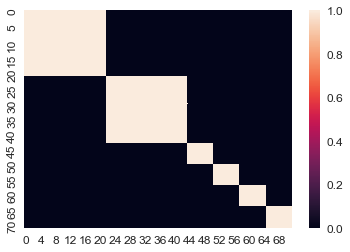

In [23]:
sns.heatmap(mask.astype(int))

In [24]:
def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(f_batch):
    f_embedded = []
    for (f_guess, f_conv) in zip(f_batch, f_test):
        f_embedded.append(embedd(f_guess, f_conv))
    return np.array(f_embedded)

In [25]:
np.mean(np.abs(embedd_batch(f_test).flatten() - f_test.flatten()))

0.0

In [26]:
f_nn_gwh_plus = embedd_batch(f_nn_gwh)

In [27]:
p_nn_gwh_plus = density_from_fock_batch(f_nn_gwh_plus)

In [28]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    p_nn_gwh_plus,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-02 11:57:06: Iteration calculation: 0
[ ] 2019-01-02 11:57:07: Iteration calculation: 1
[ ] 2019-01-02 11:57:08: Iteration calculation: 2
[ ] 2019-01-02 11:57:10: Iteration calculation: 3
[ ] 2019-01-02 11:57:12: Iteration calculation: 4
[ ] 2019-01-02 11:57:13: Iteration calculation: 5
[ ] 2019-01-02 11:57:15: Iteration calculation: 6
[ ] 2019-01-02 11:57:16: Iteration calculation: 7
[ ] 2019-01-02 11:57:17: Iteration calculation: 8
[ ] 2019-01-02 11:57:18: Iteration calculation: 9
[ ] 2019-01-02 11:57:19: Iteration calculation: 10
[ ] 2019-01-02 11:57:21: Iteration calculation: 11
[ ] 2019-01-02 11:57:21: Iteration calculation: 12
[ ] 2019-01-02 11:57:23: Iteration calculation: 13
[ ] 2019-01-02 11:57:25: Iteration calculation: 14
[ ] 2019-01-02 11:57:25: Iteration calculation: 15
[ ] 2019-01-02 11:57:27: Iteration calculation: 16
[ ] 2019-01-02 11:57:28: Iteration calculation: 17
[ ] 2019-01-02 11:57:29: Iteration calculation: 18
[ ] 2019-01-02 11:57:31: Iteration calcul

[ ] 2019-01-02 12:00:26: Iteration calculation: 160
[ ] 2019-01-02 12:00:29: Iteration calculation: 161
[ ] 2019-01-02 12:00:29: Iteration calculation: 162
[ ] 2019-01-02 12:00:31: Iteration calculation: 163
[ ] 2019-01-02 12:00:33: Iteration calculation: 164
[ ] 2019-01-02 12:00:35: Iteration calculation: 165
[ ] 2019-01-02 12:00:36: Iteration calculation: 166
[ ] 2019-01-02 12:00:38: Iteration calculation: 167
[ ] 2019-01-02 12:00:38: Iteration calculation: 168
[ ] 2019-01-02 12:00:40: Iteration calculation: 169
[ ] 2019-01-02 12:00:41: Iteration calculation: 170
[ ] 2019-01-02 12:00:41: Iteration calculation: 171
[ ] 2019-01-02 12:00:42: Iteration calculation: 172
[ ] 2019-01-02 12:00:44: Iteration calculation: 173
[ ] 2019-01-02 12:00:46: Iteration calculation: 174
[ ] 2019-01-02 12:00:47: Iteration calculation: 175
[ ] 2019-01-02 12:00:47: Iteration calculation: 176
[ ] 2019-01-02 12:00:48: Iteration calculation: 177
[ ] 2019-01-02 12:00:49: Iteration calculation: 178
[ ] 2019-01-

In [29]:
77/len(p_test)

0.38308457711442784

### Damping 

In [30]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn_gwh_plus, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-02 12:01:17: Iteration calculation: 0
[ ] 2019-01-02 12:01:18: Iteration calculation: 1
[ ] 2019-01-02 12:01:20: Iteration calculation: 2
[ ] 2019-01-02 12:01:21: Iteration calculation: 3
[ ] 2019-01-02 12:01:23: Iteration calculation: 4
[ ] 2019-01-02 12:01:24: Iteration calculation: 5
[ ] 2019-01-02 12:01:24: Iteration calculation: 6
[ ] 2019-01-02 12:01:25: Iteration calculation: 7
[ ] 2019-01-02 12:01:25: Iteration calculation: 8
[ ] 2019-01-02 12:01:26: Iteration calculation: 9
[ ] 2019-01-02 12:01:27: Iteration calculation: 10
[ ] 2019-01-02 12:01:28: Iteration calculation: 11
[ ] 2019-01-02 12:01:29: Iteration calculation: 12
[ ] 2019-01-02 12:01:31: Iteration calculation: 13
[ ] 2019-01-02 12:01:33: Iteration calculation: 14
[ ] 2019-01-02 12:01:34: Iteration calculation: 15
[ ] 2019-01-02 12:01:37: Iteration calculation: 16
[ ] 2019-01-02 12:01:40: Iteration calculation: 17
[ ] 2019-01-02 12:01:41: Iteration calculation: 18
[ ] 2019-01-02 12:01:42: Iteration calcul

[ ] 2019-01-02 12:04:06: Iteration calculation: 160
[ ] 2019-01-02 12:04:07: Iteration calculation: 161
[ ] 2019-01-02 12:04:08: Iteration calculation: 162
[ ] 2019-01-02 12:04:09: Iteration calculation: 163
[ ] 2019-01-02 12:04:10: Iteration calculation: 164
[ ] 2019-01-02 12:04:12: Iteration calculation: 165
[ ] 2019-01-02 12:04:12: Iteration calculation: 166
[ ] 2019-01-02 12:04:14: Iteration calculation: 167
[ ] 2019-01-02 12:04:14: Iteration calculation: 168
[ ] 2019-01-02 12:04:16: Iteration calculation: 169
[ ] 2019-01-02 12:04:16: Iteration calculation: 170
[ ] 2019-01-02 12:04:17: Iteration calculation: 171
[ ] 2019-01-02 12:04:17: Iteration calculation: 172
[ ] 2019-01-02 12:04:19: Iteration calculation: 173
[ ] 2019-01-02 12:04:20: Iteration calculation: 174
[ ] 2019-01-02 12:04:20: Iteration calculation: 175
[ ] 2019-01-02 12:04:21: Iteration calculation: 176
[ ] 2019-01-02 12:04:22: Iteration calculation: 177
[ ] 2019-01-02 12:04:22: Iteration calculation: 178
[ ] 2019-01-

### DIIS 

In [31]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn_gwh_plus, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-02 12:04:45: Iteration calculation: 0
[ ] 2019-01-02 12:04:46: Iteration calculation: 1
[ ] 2019-01-02 12:04:46: Iteration calculation: 2
[ ] 2019-01-02 12:04:47: Iteration calculation: 3
[ ] 2019-01-02 12:04:47: Iteration calculation: 4
[ ] 2019-01-02 12:04:48: Iteration calculation: 5
[ ] 2019-01-02 12:04:48: Iteration calculation: 6
[ ] 2019-01-02 12:04:48: Iteration calculation: 7
[ ] 2019-01-02 12:04:49: Iteration calculation: 8
[ ] 2019-01-02 12:04:49: Iteration calculation: 9
[ ] 2019-01-02 12:04:49: Iteration calculation: 10
[ ] 2019-01-02 12:04:50: Iteration calculation: 11
[ ] 2019-01-02 12:04:50: Iteration calculation: 12
[ ] 2019-01-02 12:04:51: Iteration calculation: 13
[ ] 2019-01-02 12:04:51: Iteration calculation: 14
[ ] 2019-01-02 12:04:52: Iteration calculation: 15
[ ] 2019-01-02 12:04:52: Iteration calculation: 16
[ ] 2019-01-02 12:04:53: Iteration calculation: 17
[ ] 2019-01-02 12:04:53: Iteration calculation: 18
[ ] 2019-01-02 12:04:54: Iteration calcul

[ ] 2019-01-02 12:05:59: Iteration calculation: 160
[ ] 2019-01-02 12:06:00: Iteration calculation: 161
[ ] 2019-01-02 12:06:00: Iteration calculation: 162
[ ] 2019-01-02 12:06:00: Iteration calculation: 163
[ ] 2019-01-02 12:06:01: Iteration calculation: 164
[ ] 2019-01-02 12:06:01: Iteration calculation: 165
[ ] 2019-01-02 12:06:02: Iteration calculation: 166
[ ] 2019-01-02 12:06:03: Iteration calculation: 167
[ ] 2019-01-02 12:06:03: Iteration calculation: 168
[ ] 2019-01-02 12:06:04: Iteration calculation: 169
[ ] 2019-01-02 12:06:05: Iteration calculation: 170
[ ] 2019-01-02 12:06:05: Iteration calculation: 171
[ ] 2019-01-02 12:06:06: Iteration calculation: 172
[ ] 2019-01-02 12:06:06: Iteration calculation: 173
[ ] 2019-01-02 12:06:07: Iteration calculation: 174
[ ] 2019-01-02 12:06:07: Iteration calculation: 175
[ ] 2019-01-02 12:06:08: Iteration calculation: 176
[ ] 2019-01-02 12:06:08: Iteration calculation: 177
[ ] 2019-01-02 12:06:09: Iteration calculation: 178
[ ] 2019-01-

# Reference: Embedd Classical GWH

In [32]:
f_gwh = gwh_scheme_wrapper(h_test)
f_embedded_gwh = embedd_batch(f_gwh)
p_embedded_gwh = density_from_fock_batch(f_embedded_gwh)

In [33]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.analysis import mf_initializer
    
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-02 12:08:04: Iteration calculation: 0
[ ] 2019-01-02 12:08:05: Iteration calculation: 1
[ ] 2019-01-02 12:08:06: Iteration calculation: 2
[ ] 2019-01-02 12:08:06: Iteration calculation: 3
[ ] 2019-01-02 12:08:07: Iteration calculation: 4
[ ] 2019-01-02 12:08:09: Iteration calculation: 5
[ ] 2019-01-02 12:08:10: Iteration calculation: 6
[ ] 2019-01-02 12:08:10: Iteration calculation: 7
[ ] 2019-01-02 12:08:11: Iteration calculation: 8
[ ] 2019-01-02 12:08:12: Iteration calculation: 9
[ ] 2019-01-02 12:08:12: Iteration calculation: 10
[ ] 2019-01-02 12:08:14: Iteration calculation: 11
[ ] 2019-01-02 12:08:15: Iteration calculation: 12
[ ] 2019-01-02 12:08:16: Iteration calculation: 13
[ ] 2019-01-02 12:08:18: Iteration calculation: 14
[ ] 2019-01-02 12:08:18: Iteration calculation: 15
[ ] 2019-01-02 12:08:19: Iteration calculation: 16
[ ] 2019-01-02 12:08:20: Iteration calculation: 17
[ ] 2019-01-02 12:08:21: Iteration calculation: 18
[ ] 2019-01-02 12:08:23: Iteration calcul

[ ] 2019-01-02 12:11:18: Iteration calculation: 160
[ ] 2019-01-02 12:11:18: Iteration calculation: 161
[ ] 2019-01-02 12:11:19: Iteration calculation: 162
[ ] 2019-01-02 12:11:20: Iteration calculation: 163
[ ] 2019-01-02 12:11:22: Iteration calculation: 164
[ ] 2019-01-02 12:11:24: Iteration calculation: 165
[ ] 2019-01-02 12:11:24: Iteration calculation: 166
[ ] 2019-01-02 12:11:27: Iteration calculation: 167
[ ] 2019-01-02 12:11:28: Iteration calculation: 168
[ ] 2019-01-02 12:11:29: Iteration calculation: 169
[ ] 2019-01-02 12:11:30: Iteration calculation: 170
[ ] 2019-01-02 12:11:31: Iteration calculation: 171
[ ] 2019-01-02 12:11:32: Iteration calculation: 172
[ ] 2019-01-02 12:11:33: Iteration calculation: 173
[ ] 2019-01-02 12:11:34: Iteration calculation: 174
[ ] 2019-01-02 12:11:34: Iteration calculation: 175
[ ] 2019-01-02 12:11:36: Iteration calculation: 176
[ ] 2019-01-02 12:11:38: Iteration calculation: 177
[ ] 2019-01-02 12:11:38: Iteration calculation: 178
[ ] 2019-01-

In [34]:
50/len(p_test)

0.24875621890547264

### Damping 

In [35]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_embedded_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-02 12:12:01: Iteration calculation: 0
[ ] 2019-01-02 12:12:02: Iteration calculation: 1
[ ] 2019-01-02 12:12:03: Iteration calculation: 2
[ ] 2019-01-02 12:12:04: Iteration calculation: 3
[ ] 2019-01-02 12:12:06: Iteration calculation: 4
[ ] 2019-01-02 12:12:08: Iteration calculation: 5
[ ] 2019-01-02 12:12:08: Iteration calculation: 6
[ ] 2019-01-02 12:12:09: Iteration calculation: 7
[ ] 2019-01-02 12:12:10: Iteration calculation: 8
[ ] 2019-01-02 12:12:10: Iteration calculation: 9
[ ] 2019-01-02 12:12:11: Iteration calculation: 10
[ ] 2019-01-02 12:12:12: Iteration calculation: 11
[ ] 2019-01-02 12:12:13: Iteration calculation: 12
[ ] 2019-01-02 12:12:15: Iteration calculation: 13
[ ] 2019-01-02 12:12:17: Iteration calculation: 14
[ ] 2019-01-02 12:12:18: Iteration calculation: 15
[ ] 2019-01-02 12:12:19: Iteration calculation: 16
[ ] 2019-01-02 12:12:21: Iteration calculation: 17
[ ] 2019-01-02 12:12:22: Iteration calculation: 18
[ ] 2019-01-02 12:12:24: Iteration calcul

[ ] 2019-01-02 12:15:33: Iteration calculation: 160
[ ] 2019-01-02 12:15:35: Iteration calculation: 161
[ ] 2019-01-02 12:15:36: Iteration calculation: 162
[ ] 2019-01-02 12:15:38: Iteration calculation: 163
[ ] 2019-01-02 12:15:39: Iteration calculation: 164
[ ] 2019-01-02 12:15:41: Iteration calculation: 165
[ ] 2019-01-02 12:15:41: Iteration calculation: 166
[ ] 2019-01-02 12:15:43: Iteration calculation: 167
[ ] 2019-01-02 12:15:43: Iteration calculation: 168
[ ] 2019-01-02 12:15:44: Iteration calculation: 169
[ ] 2019-01-02 12:15:44: Iteration calculation: 170
[ ] 2019-01-02 12:15:45: Iteration calculation: 171
[ ] 2019-01-02 12:15:45: Iteration calculation: 172
[ ] 2019-01-02 12:15:47: Iteration calculation: 173
[ ] 2019-01-02 12:15:47: Iteration calculation: 174
[ ] 2019-01-02 12:15:48: Iteration calculation: 175
[ ] 2019-01-02 12:15:49: Iteration calculation: 176
[ ] 2019-01-02 12:15:51: Iteration calculation: 177
[ ] 2019-01-02 12:15:51: Iteration calculation: 178
[ ] 2019-01-

### DIIS 

In [36]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_embedded_gwh, 
    molecules[1]
))

max_cycle = mf_initializer(
    molecules[1][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-02 12:16:08: Iteration calculation: 0
[ ] 2019-01-02 12:16:08: Iteration calculation: 1
[ ] 2019-01-02 12:16:08: Iteration calculation: 2
[ ] 2019-01-02 12:16:09: Iteration calculation: 3
[ ] 2019-01-02 12:16:09: Iteration calculation: 4
[ ] 2019-01-02 12:16:10: Iteration calculation: 5
[ ] 2019-01-02 12:16:10: Iteration calculation: 6
[ ] 2019-01-02 12:16:11: Iteration calculation: 7
[ ] 2019-01-02 12:16:11: Iteration calculation: 8
[ ] 2019-01-02 12:16:12: Iteration calculation: 9
[ ] 2019-01-02 12:16:12: Iteration calculation: 10
[ ] 2019-01-02 12:16:12: Iteration calculation: 11
[ ] 2019-01-02 12:16:13: Iteration calculation: 12
[ ] 2019-01-02 12:16:13: Iteration calculation: 13
[ ] 2019-01-02 12:16:14: Iteration calculation: 14
[ ] 2019-01-02 12:16:14: Iteration calculation: 15
[ ] 2019-01-02 12:16:14: Iteration calculation: 16
[ ] 2019-01-02 12:16:15: Iteration calculation: 17
[ ] 2019-01-02 12:16:15: Iteration calculation: 18
[ ] 2019-01-02 12:16:16: Iteration calcul

[ ] 2019-01-02 12:17:22: Iteration calculation: 160
[ ] 2019-01-02 12:17:22: Iteration calculation: 161
[ ] 2019-01-02 12:17:22: Iteration calculation: 162
[ ] 2019-01-02 12:17:23: Iteration calculation: 163
[ ] 2019-01-02 12:17:23: Iteration calculation: 164
[ ] 2019-01-02 12:17:24: Iteration calculation: 165
[ ] 2019-01-02 12:17:24: Iteration calculation: 166
[ ] 2019-01-02 12:17:25: Iteration calculation: 167
[ ] 2019-01-02 12:17:25: Iteration calculation: 168
[ ] 2019-01-02 12:17:26: Iteration calculation: 169
[ ] 2019-01-02 12:17:26: Iteration calculation: 170
[ ] 2019-01-02 12:17:26: Iteration calculation: 171
[ ] 2019-01-02 12:17:27: Iteration calculation: 172
[ ] 2019-01-02 12:17:27: Iteration calculation: 173
[ ] 2019-01-02 12:17:27: Iteration calculation: 174
[ ] 2019-01-02 12:17:28: Iteration calculation: 175
[ ] 2019-01-02 12:17:28: Iteration calculation: 176
[ ] 2019-01-02 12:17:29: Iteration calculation: 177
[ ] 2019-01-02 12:17:29: Iteration calculation: 178
[ ] 2019-01-